# Spoken digits
## Dataset
https://github.com/Jakobovski/free-spoken-digit-dataset

## Speech processing
https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
        

In [1]:
import tensorflow as tf
import os
import numpy as npqq
import pandas as pd

In [2]:
curr_dir = os.getcwd()

data_output_dir = curr_dir + '/mfcc_output/'

dataFrame = pd.read_csv('data/data.csv')

jackson_data = dataFrame.loc[dataFrame.label == 'jackson']
nicolas_data = dataFrame.loc[dataFrame.label == 'nicolas']
theo_data = dataFrame.loc[dataFrame.label == 'theo']
yweweler_data = dataFrame.loc[dataFrame.label == 'yweweler']

def preprocess(data):
    """Splits data to train and test set

    Parameters:
    data (string): files {label}_{name}_{digit}.wav

    Returns:
    tuple: returns test and train data

    """
    data = data.reindex(np.random.permutation(data.index))
    train, test = (data.head(400), data.tail(100))
    
    
    return train, test


In [3]:
# Split up data

jackson_train, jackson_test=preprocess(jackson_data)
nicolas_train, nicolas_test=preprocess(nicolas_data)
theo_train, theo_test=preprocess(theo_data)
yweweler_train, yweweler_test=preprocess(yweweler_data)

In [4]:
print(jackson_data.count())
print(jackson_data.head(3))
print("================================================")
print(nicolas_data.count())
print(nicolas_data.head(3))
print("================================================")
print(theo_data.count())
print(theo_data.head(3))
print("================================================")
print(yweweler_data.count())
print(yweweler_data.head(3))

file     500
label    500
dtype: int64
                       file    label
0   jackson/0_jackson_0.wav  jackson
1   jackson/0_jackson_1.wav  jackson
2  jackson/0_jackson_10.wav  jackson
file     500
label    500
dtype: int64
                         file    label
500   nicolas/0_nicolas_0.wav  nicolas
501   nicolas/0_nicolas_1.wav  nicolas
502  nicolas/0_nicolas_10.wav  nicolas
file     500
label    500
dtype: int64
                    file label
1000   theo/0_theo_0.wav  theo
1001   theo/0_theo_1.wav  theo
1002  theo/0_theo_10.wav  theo
file     500
label    500
dtype: int64
                            file     label
1500   yweweler/0_yweweler_0.wav  yweweler
1501   yweweler/0_yweweler_1.wav  yweweler
1502  yweweler/0_yweweler_10.wav  yweweler


data/jackson/0_jackson_0.wav
data/nicolas/0_nicolas_0.wav
data/theo/0_theo_0.wav
data/yweweler/0_yweweler_0.wav


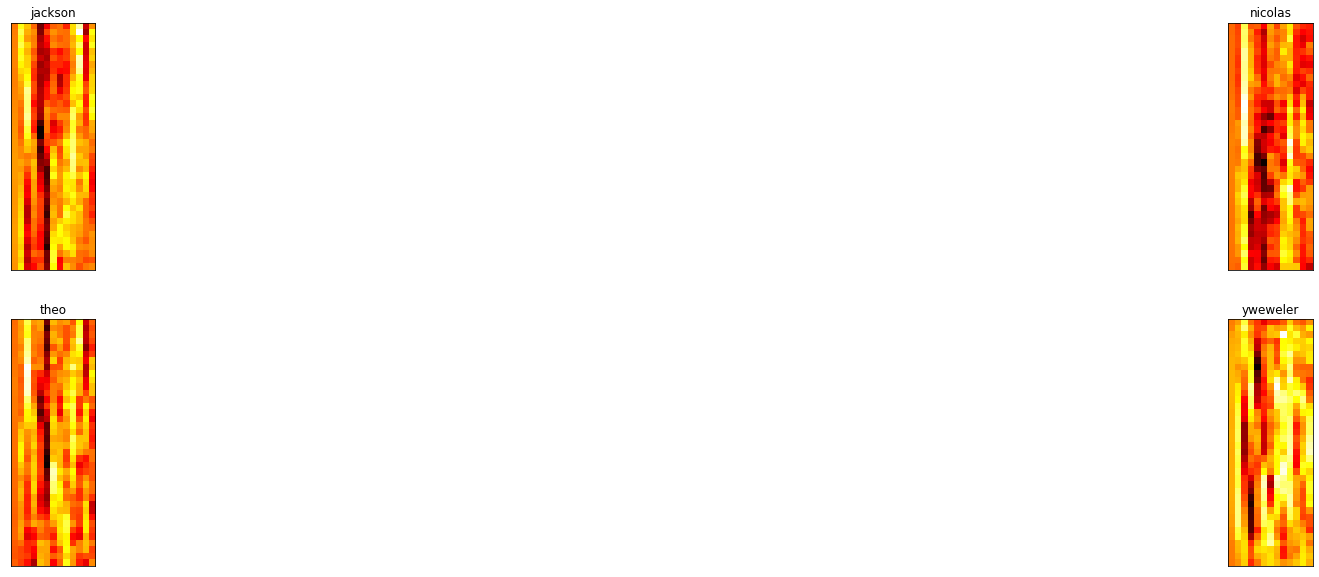

In [5]:
from python_speech_features import mfcc
import wave
import librosa.display
import matplotlib.pyplot as plt

def getFrameRate():
    frame_rate=0
    #prev_frame_rate=-1
    #curr_frame_rate=0
    for file_name in dataFrame['file']:
        with wave.open('data/' + file_name, "rb") as wave_file:
            frame_rate = wave_file.getframerate()
            break
        #if prev_frame_rate < 0:
        #    continue
        #if prev_frame_rate != curr_frame_rate:
        #    raise Exception("Invalid frame rate")
        #    
        #if frame_rate < curr_frame_rate:
        #    frame_rate = curr_frame_rate
    
    return frame_rate

def displayMfccExamples(mfcc_samples):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True,figsize=(40,10))
    i=0
    for x in range(2):
        for y in range(2):
            axes[x,y].set_title(list(mfcc_samples.keys())[i])
            axes[x,y].imshow(list(mfcc_samples.values())[i],
                            cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
    return
    
SAMPLING_RATE = getFrameRate()
classes = dataFrame.label.unique()
samples = {}

for aClass in classes:
    fileName = dataFrame[dataFrame.label == aClass].iloc[0].file
    filePath = 'data/' + fileName
    print (filePath)
    w, rate = librosa.load(filePath, sr=SAMPLING_RATE)
    samples[aClass] = mfcc(w[:rate], rate)
    
displayMfccExamples(samples)
plt.show()

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

labels_count = len(classes)

X = []
y = []

def getOneHotVectorViaClass(aClass):
    arr = np.zeros(labels_count)
    i = np.where(classes == aClass)
    arr[i] = 1
    return arr

MFCC_MAX_LEN = 100 #2000
MFCC_NUM = 10 # 20

def wav2mfcc(wave, max_len=MFCC_MAX_LEN):
    # mfcc = librosa.feature.mfcc(wave, sr=16000)
    mfcc = librosa.feature.mfcc(wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

def append_X_Y(aClass, wave):
    y.append(getOneHotVectorViaClass(aClass))
    audio_mfcc = wav2mfcc(wave)
    X.append(audio_mfcc)
    
train_data = pd.concat([jackson_train, nicolas_train, yweweler_train, theo_train])

for index, row in tqdm(train_data.iterrows()):
    label = row["label"]
    wave, sr = librosa.load('data/' + row["file"], mono=True, sr=SAMPLING_RATE)
    wave = wave
    
    append_X_Y(label, wave)


Using TensorFlow backend.
1600it [00:06, 260.02it/s]


In [7]:
X = np.array(X)
y = np.array(y)
print("X shape: " , X.shape)
print("Length of y: ", len(y))
X.shape[0] == len(y)

X shape:  (1600, 10, 100)
Length of y:  1600


True

In [8]:
# y_hot = to_categorical(y)
y_hot = y
print(y_hot[0])

[1. 0. 0. 0.]


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size= 0.3, random_state=True, shuffle=True)

In [10]:
print(X_train.shape)
print(X_test.shape)

(1120, 10, 100)
(480, 10, 100)


In [11]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [12]:
# Feature dimension
feature_dim_1 = MFCC_NUM
# Second dimension of the feature is dim2
feature_dim_2 = MFCC_MAX_LEN
channel = 1
epochs = 10
batch_size = 50
verbose = 1
num_classes = len(classes)

In [13]:
# Reshaping to perform 2D convolution
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = y_train
y_test_hot = y_test

(1120, 10, 100)


In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

def get_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', strides=(1, 1), padding="same", input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', strides=(1, 1), padding="same"))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', strides=(1, 1), padding="same"))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu', strides=(1, 1), padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [15]:
model = get_model()

model.summary()
model.compile(loss='£',
              optimizer='adam',
              metrics=['acc','mse'])
history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 100, 16)       80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 100, 32)       2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 100, 64)       8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 100, 128)      32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 50, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50, 128)        0         
______________________

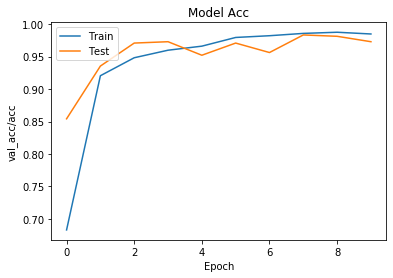

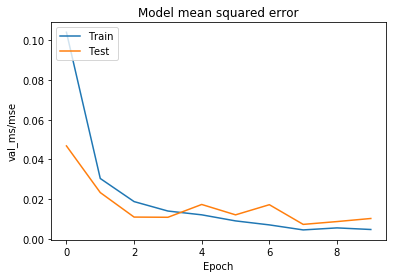

In [23]:
from matplotlib import pyplot

pyplot.title('Model Acc')
pyplot.ylabel('val_acc/acc')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.show()

pyplot.title('Model mean squared error')
pyplot.ylabel('val_ms/mse')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['val_mean_squared_error'])
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.show()


In [19]:
combDf = pd.concat([nicolas_test.head(3), jackson_test.head(3), yweweler_test.head(3)])
combDf = combDf.sample(frac=1)
#print(combDf)

for index, row in tqdm(combDf.iterrows()):
    wave, sr = librosa.load('data/' + row["file"], mono=True, sr=SAMPLING_RATE)
    #wave = wave[::3]
    
    mfcc = wav2mfcc(wave)
    X_test = mfcc.reshape(1, feature_dim_1, feature_dim_2, channel)
    preds = model.predict(X_test)[0]
    
    targetIndex=np.where(preds == np.amax(preds))[0]
    print(classes)
    print(preds)
    tmpPreds = map(lambda pred: round(int(pred*100)/float(100), 4), preds)
    print(list(tmpPreds))
    print('Input: ', row['file'], ' pred: ', classes[targetIndex], '\n\n\n')

9it [00:00, 91.17it/s]

['jackson' 'nicolas' 'theo' 'yweweler']
[2.7661482e-08 1.0000000e+00 3.9295456e-09 3.7104851e-08]
[0.0, 1.0, 0.0, 0.0]
Input:  nicolas/2_nicolas_49.wav  pred:  ['nicolas'] 



['jackson' 'nicolas' 'theo' 'yweweler']
[9.9999046e-01 6.6763035e-09 9.4961424e-06 1.3819316e-12]
[0.99, 0.0, 0.0, 0.0]
Input:  jackson/0_jackson_3.wav  pred:  ['jackson'] 



['jackson' 'nicolas' 'theo' 'yweweler']
[1.0000000e+00 7.4007250e-10 1.5887652e-08 2.8475426e-13]
[1.0, 0.0, 0.0, 0.0]
Input:  jackson/6_jackson_19.wav  pred:  ['jackson'] 



['jackson' 'nicolas' 'theo' 'yweweler']
[1.3387573e-08 8.6863068e-09 2.1257490e-06 9.9999785e-01]
[0.0, 0.0, 0.0, 0.99]
Input:  yweweler/9_yweweler_25.wav  pred:  ['yweweler'] 



['jackson' 'nicolas' 'theo' 'yweweler']
[1.7209439e-07 9.9999440e-01 5.1470869e-07 4.8966690e-06]
[0.0, 0.99, 0.0, 0.0]
Input:  nicolas/1_nicolas_32.wav  pred:  ['nicolas'] 



['jackson' 'nicolas' 'theo' 'yweweler']
[4.0783343e-05 9.9985027e-01 6.6663473e-05 4.2268421e-05]
[0.0, 0.99, 0.0, 